In [1]:
import game as gm
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

from scipy.optimize import root, minimize_scalar, OptimizeResult, RootResults

In [2]:
# test game equilibrium
game = gm.Game2(n=5, r=0.5, M1=1, M2=1, sigma1=1, sigma2=1)
game.equilibrium(theta_1=1, theta_2=1)

(0.2325928947280938, 0.2325928947280938)

In [3]:
# Optimal theta_1 w.r.t. theta_2
# Increasing if r < 1; Decreasing if r > 1

def theta2_opt(theta1, n, r, M1, M2, sigma1, sigma2, gamma = 0.25, dist: str = 'norm'):
	"""Given theta_1, find the optimal theta_2
	"""
	game = gm.Game2(n, r, M1, M2, sigma1, sigma2, dist)
	def res(theta2):
		re = game.equilibrium(theta1, theta2)
		assert isinstance(re, tuple)
		d1, d2 = re[0], re[1]
		D2 = gm.training_perf_simpler(r, d2, [d1])
		privacy_cost_degree = 1
		return -(D2 - gamma * (theta2 * d2)**privacy_cost_degree)
	re = minimize_scalar(res, bounds=[0, 1])
	assert isinstance(re, OptimizeResult)
	if re.success:
		return re.x

def theta2_opt_approx(theta1, n, r, M1, M2, sigma1, sigma2, gamma = 0.25, dist: str = 'norm'):
	"""Given theta_1, find the approximated optimal theta_2
	"""
	game = gm.Game2(n, r, M1, M2, sigma1, sigma2, dist)
	An = game.An
	tM1 = M1 / sigma1
	tM2 = M2 / sigma2
	tmp = 2 * tM2 * (tM1 - gamma * tM2) * theta1**2 + tM1 * (tM1 + 2 * tM2 - 2 * tM2 * gamma) * theta1 + tM1**2
	nume = 2 * r * (tM1 - gamma * tM2) - tM1 / 2 - An * (r - 0.5) * tmp
	denom = tM1 * (4 * gamma * r - An * (2 * r - 1) * (2 * tM2 * gamma - tM1 * theta1 + 2 * tM2 * gamma * theta1))
	return nume / denom

In [4]:
def theta1_opt(theta2, n, r, M1, M2, sigma1, sigma2, gamma = 0.25, dist: str = 'norm'):
	"""Given theta_1, find the optimal theta_2
	"""
	game = gm.Game2(n, r, M1, M2, sigma1, sigma2, dist)
	def res(theta1):
		re = game.equilibrium(theta1, theta2)
		assert isinstance(re, tuple)
		d1, d2 = re[0], re[1]
		D1 = gm.training_perf_simpler(r, d1, [d2])
		privacy_cost_degree = 1
		return -(D1 - gamma * (theta1 * d1)**privacy_cost_degree)
	re = minimize_scalar(res, bounds=[0, 1])
	assert isinstance(re, OptimizeResult)
	if re.success:
		return re.x

def theta1_opt_approx(theta2, n, r, M1, M2, sigma1, sigma2, gamma = 0.25, dist: str = 'norm'):
	"""Given theta_1, find the approximated optimal theta_2
	"""
	game = gm.Game2(n, r, M1, M2, sigma1, sigma2, dist)
	An = game.An
	tM1 = M1 / sigma1
	tM2 = M2 / sigma2
	tmp = 2 * tM1 * (tM2 - gamma * tM1) * theta2**2 + tM2 * (tM2 + 2 * tM1 - 2 * tM1 * gamma) * theta2 + tM2**2
	nume = 2 * r * (tM2 - gamma * tM1) - tM2 / 2 - An * (r - 0.5) * tmp
	denom = tM2 * (4 * gamma * r - An * (2 * r - 1) * (2 * tM1 * gamma - tM2 * theta2 + 2 * tM1 * gamma * theta2))
	return nume / denom

In [5]:
def eq_policies(n, r, M1, M2, sigma1, sigma2, gamma1 = 0.25, gamma2 = 0.25, dist: str = 'norm'):
	def res(thetas):
		theta1, theta2 = thetas
		sol_theta1_opt = theta1_opt(theta2, n, r, M1, M2, sigma1, sigma2, gamma1)
		sol_theta2_opt = theta2_opt(theta1, n, r, M1, M2, sigma1, sigma2, gamma2)
		return theta1 - sol_theta1_opt, theta2 - sol_theta2_opt
	sol: RootResults = root(res, x0=(0.5, 0.5))
	if sol.success:
		return sol.x

def approx_policies(n, r, M1, M2, sigma1, sigma2, gamma1 = 0.25, gamma2 = 0.25, dist: str = 'norm'):
	def res(thetas):
		theta1, theta2 = thetas
		sol_theta1_opt = theta1_opt_approx(theta2, n, r, M1, M2, sigma1, sigma2, gamma1)
		sol_theta2_opt = theta2_opt_approx(theta1, n, r, M1, M2, sigma1, sigma2, gamma2)
		return theta1 - sol_theta1_opt, theta2 - sol_theta2_opt
	sol: RootResults = root(res, x0=(0.5, 0.5))
	if sol.success:
		return sol.x

In [6]:
r = 0.48
gamma1 = 0.52
gamma2 = 0.49

print('theta1 -- M1')
for i in range(1, 21):
	M1 = 99 + i / 10
	M2 = 100
	sol_theta1_opt = theta1_opt(theta2=0.5, n=5, r=r, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma=gamma1)
	sol_theta1_opt_approx = theta1_opt_approx(theta2=0.5, n=5, r=r, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma=gamma1)
	print(M1, sol_theta1_opt, sol_theta1_opt_approx)
print()
print('theta1 -- M2')
for i in range(1, 21):
	M1 = 100
	M2 = 99 + i / 10
	sol_theta1_opt = theta1_opt(theta2 = 0.5, n=5, r=r, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma=gamma2)
	sol_theta1_opt_approx = theta1_opt_approx(theta2 = 0.5, n=5, r=r, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma=gamma2)
	print(M2, sol_theta1_opt, sol_theta1_opt_approx)

theta1 -- M1
99.1 0.579340515545441 0.5052263220235015
99.2 0.5788402210645621 0.5047111459124946
99.3 0.5783386042180415 0.5041966046849597
99.4 0.5778384070726292 0.5036826969418429
99.5 0.577338531911407 0.5031694212881973
99.6 0.5768403705344918 0.5026567763331693
99.7 0.5763382686570685 0.5021447606899828
99.8 0.5758397654837205 0.5016333729759241
99.9 0.575337759281007 0.5011226118123272
100.0 0.5748388319346486 0.5006124758245597
100.1 0.5743385365548365 0.5001029636420067
100.2 0.5738395497480945 0.4995940738980574
100.3 0.573338753484107 0.49908580523009033
100.4 0.5728398284402086 0.49857815627945706
100.5 0.5723401886153748 0.49807112569147083
100.6 0.5718404106108411 0.4975647121153895
100.7 0.5713383694930992 0.4970589142044021
100.8 0.5708383376942493 0.4965537306156149
100.9 0.5703416075686628 0.4960491600100365
101.0 0.5698405019104609 0.4955452010525642

theta1 -- M2
99.1 0.580058346996514 0.5584239485772409
99.2 0.5794744451627153 0.5592642289482446
99.3 0.57889282394

## Effect of $M$, fix $\gamma$

In [7]:
# symmetric markets
r = 0.48
gamma1 = 0.25
gamma2 = 0.25

arr_M1 = []
arr_theta1_eq = []
arr_theta1_ap = []
arr_theta2_eq = []
arr_theta2_ap = []

for i in range(-20, 20):
	M1 = 1 + i / 100
	M2 = M1
	arr_M1.append(M1)
	sol_theta1_eq, sol_theta2_eq = approx_policies(n=5, r=r, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	sol_theta1_ap, sol_theta2_ap = eq_policies(n=5, r=r, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	arr_theta1_eq.append(sol_theta1_eq)
	arr_theta1_ap.append(sol_theta1_ap)
	arr_theta2_eq.append(sol_theta2_eq)
	arr_theta2_ap.append(sol_theta2_ap)
	print(round(M1, 2), sol_theta1_eq, sol_theta2_eq)

0.8 0.4760142328519071 0.4760142328519071
0.81 0.47624218831967946 0.47624218831967946
0.82 0.47647032283874985 0.47647032283874985
0.83 0.4766986367008051 0.4766986367008051
0.84 0.47692713019824473 0.47692713019824473
0.85 0.47715580362418486 0.47715580362418486
0.86 0.47738465727246077 0.47738465727246077
0.87 0.4776136914376286 0.4776136914376286
0.88 0.47784290641496835 0.47784290641496835
0.89 0.4780723025004844 0.4780723025004844
0.9 0.4783018799909118 0.4783018799909118
0.91 0.47853163918371394 0.47853163918371394
0.92 0.4787615803770888 0.4787615803770888
0.93 0.4789917038699695 0.4789917038699695
0.94 0.4792220099620265 0.4792220099620265
0.95 0.47945249895367154 0.47945249895367154
0.96 0.4796831711460588 0.4796831711460588
0.97 0.4799140268410883 0.4799140268410883
0.98 0.4801450663414068 0.4801450663414068
0.99 0.4803762899504124 0.4803762899504124
1.0 0.4806076979722563 0.4806076979722563
1.01 0.4808392907118442 0.4808392907118442
1.02 0.4810710684748394 0.481071068474839

In [8]:
# Plot: effect of gamma_1 if r < 0.5
gamma1 = 0.25
gamma2 = 0.25
M2 = 1

arr_M1 = []
arr_theta1_eq_rsmall = []
arr_theta1_ap_rsmall = []
arr_theta2_eq_rsmall = []
arr_theta2_ap_rsmall = []
arr_theta1_eq_rlarge = []
arr_theta1_ap_rlarge = []
arr_theta2_eq_rlarge = []
arr_theta2_ap_rlarge = []

for i in range(-10, 10):
	M1 = 1 + i / 100
	arr_M1.append(M1)
	sol_theta1_eq_rsmall, sol_theta2_eq_rsmall = approx_policies(\
		n=5, r=0.48, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	sol_theta1_ap_rsmall, sol_theta2_ap_rsmall = eq_policies(\
		n=5, r=0.48, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	arr_theta1_eq_rsmall.append(sol_theta1_eq_rsmall)
	arr_theta1_ap_rsmall.append(sol_theta1_ap_rsmall)
	arr_theta2_eq_rsmall.append(sol_theta2_eq_rsmall)
	arr_theta2_ap_rsmall.append(sol_theta2_ap_rsmall)
	sol_theta1_eq_rlarge, sol_theta2_eq_rlarge = approx_policies(\
		n=5, r=0.52, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	sol_theta1_ap_rlarge, sol_theta2_ap_rlarge = eq_policies(\
		n=5, r=0.52, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	arr_theta1_eq_rlarge.append(sol_theta1_eq_rlarge)
	arr_theta1_ap_rlarge.append(sol_theta1_ap_rlarge)
	arr_theta2_eq_rlarge.append(sol_theta2_eq_rlarge)
	arr_theta2_ap_rlarge.append(sol_theta2_ap_rlarge)


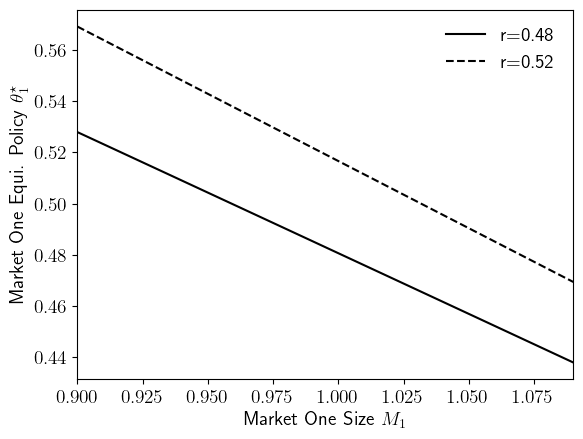

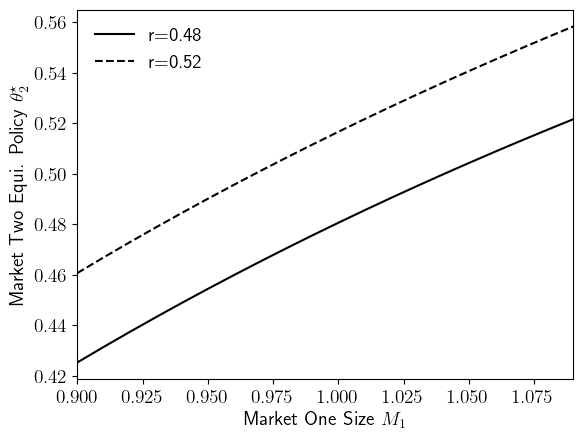

In [9]:
fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 14})
plt.xlim((arr_M1[0], arr_M1[-1]))
plt.ylabel(r'Market One Equi. Policy $\theta_1^\star$')
plt.xlabel(r'Market One Size $M_1$')
plt.plot(arr_M1, arr_theta1_eq_rsmall, color='black', linestyle='solid', label=f'r=0.48')
plt.plot(arr_M1, arr_theta1_eq_rlarge, color='black', linestyle='dashed', label=f'r=0.52')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_simulGameEq_theta1_M1.pdf', bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 14})
plt.xlim((arr_M1[0], arr_M1[-1]))
plt.ylabel(r'Market Two Equi. Policy $\theta_2^\star$')
plt.xlabel(r'Market One Size $M_1$')
plt.plot(arr_M1, arr_theta2_eq_rsmall, color='black', linestyle='solid', label=f'r=0.48')
plt.plot(arr_M1, arr_theta2_eq_rlarge, color='black', linestyle='dashed', label=f'r=0.52')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_simulGameEq_theta2_M1.pdf', bbox_inches='tight')
plt.show()

## Effect of $\gamma$, given $M$

In [10]:
# Plot: effect of gamma_1 if r < 0.5
M1 = 1
M2 = 1
gamma2 = 0.25

arr_gamma1 = []
arr_theta1_eq_rsmall = []
arr_theta1_ap_rsmall = []
arr_theta2_eq_rsmall = []
arr_theta2_ap_rsmall = []
arr_theta1_eq_rlarge = []
arr_theta1_ap_rlarge = []
arr_theta2_eq_rlarge = []
arr_theta2_ap_rlarge = []

for i in range(0, 17):
	gamma1 = 0.167 + i / 100
	arr_gamma1.append(gamma1)
	sol_theta1_eq_rsmall, sol_theta2_eq_rsmall = approx_policies(\
		n=5, r=0.48, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	sol_theta1_ap_rsmall, sol_theta2_ap_rsmall = eq_policies(\
		n=5, r=0.48, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	arr_theta1_eq_rsmall.append(sol_theta1_eq_rsmall)
	arr_theta1_ap_rsmall.append(sol_theta1_ap_rsmall)
	arr_theta2_eq_rsmall.append(sol_theta2_eq_rsmall)
	arr_theta2_ap_rsmall.append(sol_theta2_ap_rsmall)
	sol_theta1_eq_rlarge, sol_theta2_eq_rlarge = approx_policies(\
		n=5, r=0.52, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	sol_theta1_ap_rlarge, sol_theta2_ap_rlarge = eq_policies(\
		n=5, r=0.52, M1=M1, M2=M2, sigma1=1, sigma2=1, gamma1=gamma1, gamma2=gamma2)
	arr_theta1_eq_rlarge.append(sol_theta1_eq_rlarge)
	arr_theta2_eq_rlarge.append(sol_theta2_eq_rlarge)
	arr_theta1_ap_rlarge.append(sol_theta1_ap_rlarge)
	arr_theta2_ap_rlarge.append(sol_theta2_ap_rlarge)


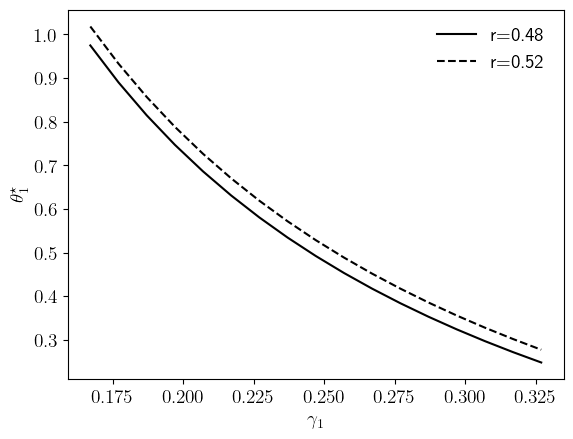

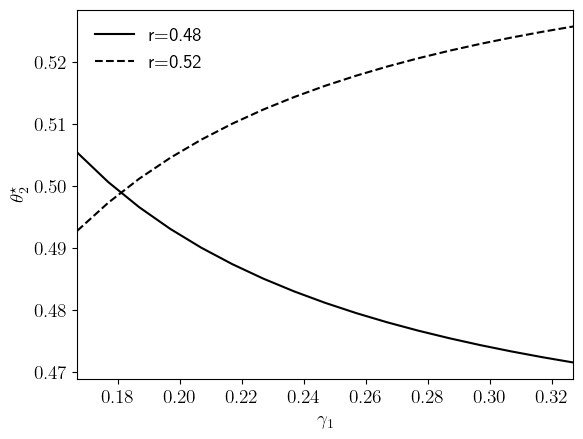

In [11]:
fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 14})
#plt.xlim((arr_gamma1[0], arr_gamma1[-1]))
plt.ylabel(r'$\theta_1^\star$')
plt.xlabel(r'$\gamma_1$')
plt.plot(arr_gamma1, arr_theta1_eq_rsmall, color='black', linestyle='solid', label=f'r=0.48')
plt.plot(arr_gamma1, arr_theta1_eq_rlarge, color='black', linestyle='dashed', label=f'r=0.52')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_simulGameEq_theta1_gamma1.pdf', bbox_inches='tight')
plt.show()

fig, ax2 = plt.subplots()
plt.rcParams.update({'font.size': 14})
plt.xlim((arr_gamma1[0], arr_gamma1[-1]))
plt.ylabel(r'$\theta_2^\star$')
plt.xlabel(r'$\gamma_1$')
plt.plot(arr_gamma1, arr_theta2_eq_rsmall, color='black', linestyle='solid', label=f'r=0.48')
plt.plot(arr_gamma1, arr_theta2_eq_rlarge, color='black', linestyle='dashed', label=f'r=0.52')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_simulGameEq_theta2_gamma1.pdf', bbox_inches='tight')
plt.show()